In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
import PIL
## checking for xrays and their respective masks
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

DIR = "/kaggle/input/chest-xray-masks-and-labels/data/"

lung_image_paths = glob(os.path.join(DIR,"Lung Segmentation/CXR_png/*.png"))
mask_image_paths = glob(os.path.join(DIR,"Lung Segmentation/masks/*.png"))

related_paths = defaultdict(list)

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)

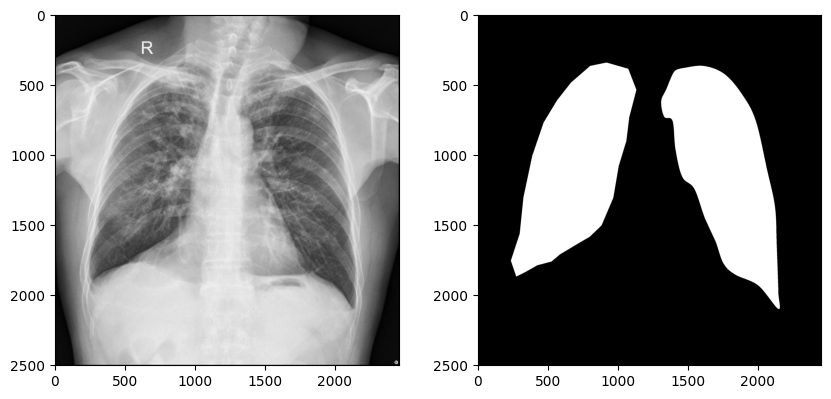

In [3]:
xray_num = 5
img_path = paths_df["image_path"][xray_num]
mask_path = paths_df["mask_path"][xray_num]

img = PIL.Image.open(img_path)
mask = PIL.Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray")

In [4]:
from tqdm import tqdm
import cv2
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)
  
    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])
        # mask_array.append(resized_image)

    return img_array, mask_array

img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (256,256), color_mode = "gray")

100%|██████████| 704/704 [00:51<00:00, 13.55it/s]


In [5]:
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(img_array, mask_array, test_size = 0.2, random_state= 42)

img_side_size = 256
img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size, 1)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size, 1)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size, 1)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size, 1)

In [6]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation

def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def residual_block(inputs, filters, kernel_size=(3, 3), activation='relu'):
    x = conv_block(inputs, filters, kernel_size, activation)
    x = concatenate([x, inputs], axis=3)
    return x

def unet_with_resnet(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = residual_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = residual_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Middle
    conv5 = residual_block(pool4, 512)

    # Decoder
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = residual_block(up6, 256)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = residual_block(up7, 128)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = residual_block(up8, 64)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = residual_block(up9, 32)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

# Create the model


In [7]:
EPOCHS = 100

# Compile your model with appropriate metrics
model = unet_with_resnet()
# Adjust learning rate
model.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy",
              metrics=[dice_coef, 'accuracy'])


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
!pip install visualkeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 39.8 MB/s eta 0:00:00


In [9]:
!pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-hq3w324b
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-hq3w324b
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done


In [10]:
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output1.png').show() # write and show

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpse5uagqx.PNG'


/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmp_d4r7zeb.PNG'


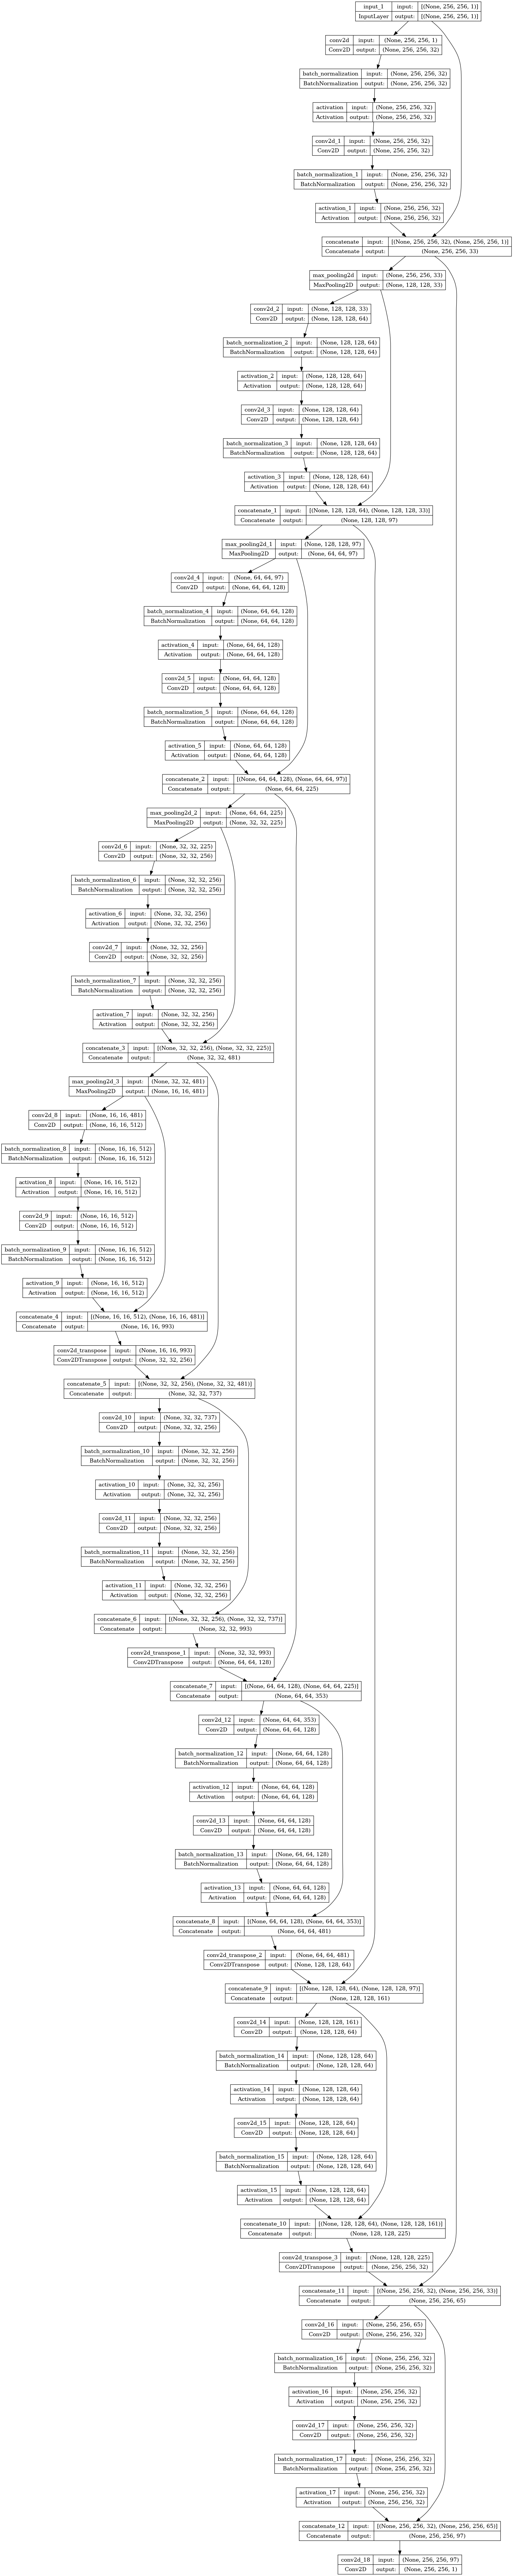

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)


In [ ]:

# Early stopping based on validation dice coefficient
earlystopping = EarlyStopping(monitor='val_dice_coef', patience=10, mode='max')

# Train your model
history = model.fit(x=img_train, y=mask_train, validation_data=(img_test, mask_test),
                    epochs=EPOCHS, batch_size=16, callbacks=[earlystopping])

Epoch 1/100
36/36 [==============================] - 27s 354ms/step - loss: 0.3318 - dice_coef: 0.6126 - accuracy: 0.8597 - val_loss: 0.6178 - val_dice_coef: 0.3411 - val_accuracy: 0.7633
Epoch 2/100
36/36 [==============================] - 8s 225ms/step - loss: 0.0907 - dice_coef: 0.8877 - accuracy: 0.9677 - val_loss: 0.4735 - val_dice_coef: 0.3143 - val_accuracy: 0.7518
Epoch 3/100
36/36 [==============================] - 8s 227ms/step - loss: 0.0713 - dice_coef: 0.9178 - accuracy: 0.9733 - val_loss: 0.7292 - val_dice_coef: 0.1148 - val_accuracy: 0.7454
Epoch 4/100
36/36 [==============================] - 8s 226ms/step - loss: 0.0626 - dice_coef: 0.9275 - accuracy: 0.9762 - val_loss: 0.7877 - val_dice_coef: 0.0911 - val_accuracy: 0.7454
Epoch 5/100
36/36 [==============================] - 8s 225ms/step - loss: 0.0594 - dice_coef: 0.9313 - accuracy: 0.9771 - val_loss: 0.8082 - val_dice_coef: 0.0905 - val_accuracy: 0.7454
Epoch 6/100
36/36 [==============================] - 8s 226ms/st

In [ ]:
def test_on_image(model, img_array, img_num, img_side_size=128, file_name=None):
    pred = model.predict(img_array[img_num].reshape(1, img_side_size, img_side_size, 1))
    pred[pred > 0.5] = 1.0
    pred[pred < 0.5] = 0.0
    fig = plt.figure(figsize=(15, 10))

    plt.subplot(2, 4, 1)  # Increase the number of rows to accommodate the file name
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap="Blues")
    plt.title("Forecast")
    plt.axis("off")

    plt.subplot(2, 4, 2)  # Increase the number of rows to accommodate the file name
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap="Blues")
    plt.title("Mask")
    plt.axis("off")

    plt.subplot(2, 4, 3)  # Increase the number of rows to accommodate the file name
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap="Blues", alpha=0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap="PuBu", alpha=0.3)
    plt.title("Overlay")
    plt.axis("off")

    plt.subplot(2, 4, 4)  # Increase the number of rows to accommodate the file name
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    if file_name is not None:
        plt.subplot(2, 4, 5)  # Create a new row for the file name
        plt.text(0.5, 0.5, file_name, fontsize=12, ha="center")
        plt.axis("off")

    plt.show()

    return pred


def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

IMG_NUM = 3
prediction = test_on_image(model, img_array = img_test, img_num = IMG_NUM, img_side_size = 256)
dice_coef_test(y_true = mask_test[IMG_NUM], y_pred = prediction)

In [ ]:
def get_metrics(history):
    fig = plt.figure(figsize=(12, 8))

    # Plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history["loss"], label="Training loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Binary Cross Entropy")
    plt.title("Loss")

    # Plot training and validation dice coefficient
    plt.subplot(2, 2, 2)
    plt.plot(history.history["dice_coef"], label="Training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label="Validation dice coefficient")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coefficient")
    plt.title("Dice Coefficient")

    # Plot training and validation accuracy
    plt.subplot(2, 2, 3)
    plt.plot(history.history["accuracy"], label="Training accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")

    plt.tight_layout()
    plt.show()

# Call the function to plot metrics
get_metrics(history=history)


In [ ]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:30]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
activations = activation_model.predict(img_array[1].reshape(1,256,256,1)) 

In [ ]:
num = 0
size = 256
plt.imshow(activations[num].reshape(size, size))

In [ ]:
def test_accuracy(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred > threshold).astype(int)
    correct_predictions = np.sum(y_true == y_pred_binary)
    total_pixels = y_true.size
    accuracy = correct_predictions / total_pixels
    return accuracy

# Calculate test accuracy for each test image
test_accuracies = []
threshold = 0.5  # You can adjust this threshold
for i in range(len(img_test)):
    prediction = test_on_image(model, img_array=img_test, img_num=i, img_side_size=256)
    accuracy = test_accuracy(mask_test[i], prediction, threshold)
    test_accuracies.append(accuracy)

# Calculate the average test accuracy
average_test_accuracy = np.mean(test_accuracies)
print("Test Accuracy (Average):", average_test_accuracy)


In [ ]:
test_loss, test_dice_coef = model.evaluate(img_test, mask_test)
print("Test Dice Coefficient:", test_dice_coef)
print("Test Loss:", test_loss)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Function to preprocess and predict on a single image
def predict_single_image(model, image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize and preprocess the image
    input_size = (256, 256)
    image = cv2.resize(image, input_size)
    image = image / 255.0
    image = image.reshape(1, *input_size, 1)
    
    # Make predictions
    predictions = model.predict(image)
    
    return image, predictions

# List of image file paths you want to predict on
image_paths = [
    "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/test/CHNCXR_0025_0.png",
    "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/test/CHNCXR_0039_0.png",
    "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/test/CHNCXR_0181_0.png",
    "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/test/CHNCXR_0213_0.png",
    "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/test/CHNCXR_0355_1.png",
    "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/test/CHNCXR_0489_1.png",
    "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/test/CHNCXR_0495_1.png",
    "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/test/CHNCXR_0564_1.png"
]

# Make predictions for each image and store results
results = []

for image_path in image_paths:
    image, predictions = predict_single_image(model, image_path)
    results.append((image, predictions))

# Visualize the results
for i, (image, predictions) in enumerate(results):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image[0, :, :, 0], cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predictions[0, :, :, 0], cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    # Overlay the mask on the original image for visualization
    overlay = image[0, :, :, 0] + 0.3 * predictions[0, :, :, 0]
    plt.imshow(overlay, cmap="gray")
    plt.title("Overlay")
    plt.axis("off")

    plt.show()
